In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.models import load_model


In [3]:
model=load_model('cats_and_dogs_small_1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [12]:
img_path='E:/deeplearningtry/dogs-vs-cats/test1/699.jpg'

from keras.preprocessing import image
import numpy as np
img=image.load_img(img_path,target_size=(150,150))
img_tensor=image.img_to_array(img)
img_tensor=np.expand_dims(img_tensor,axis=0)

In [16]:
print(img_tensor.shape)
img_tensor /= 255.

(1, 150, 150, 3)


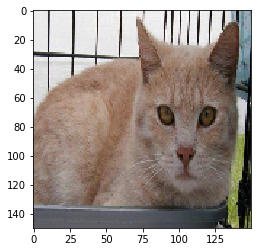

In [17]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [18]:
from keras import models

In [19]:
layer_outputs=[layer.output for layer in model.layers[:8]]
activation_model=models.Model(inputs=model.input,outputs=layer_outputs)

In [20]:
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(?, 7, 7, 128) dtype=float32>]

In [21]:
activations =activation_model.predict(img_tensor)

In [22]:
first_layer_activation=activations[0]

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


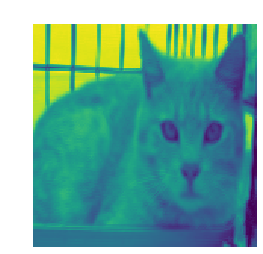

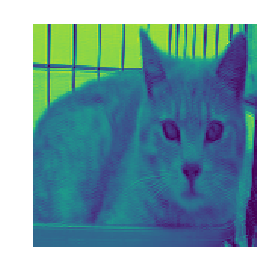

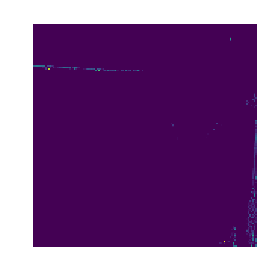

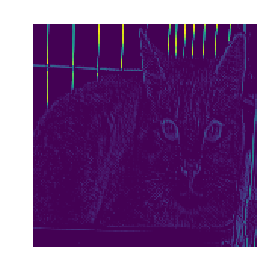

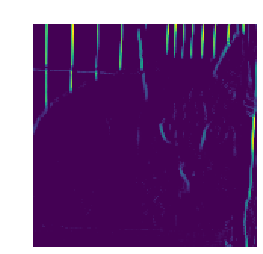

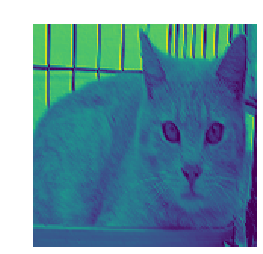

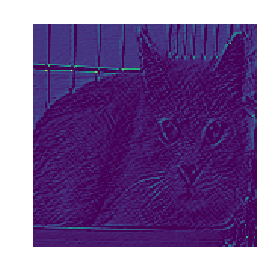

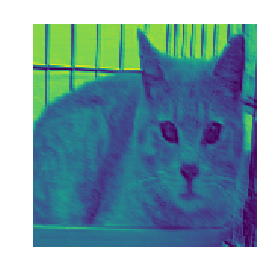

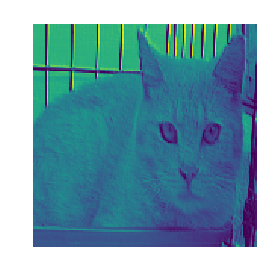

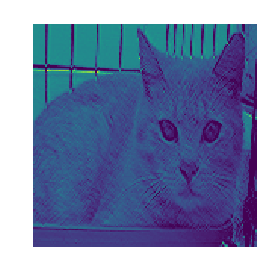

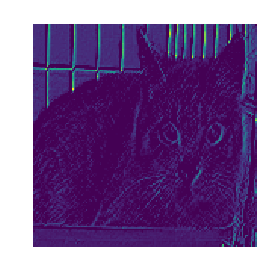

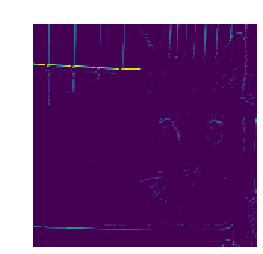

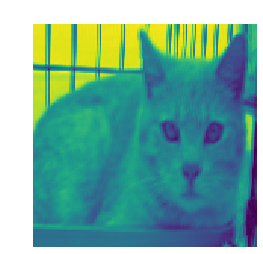

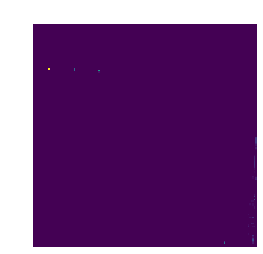

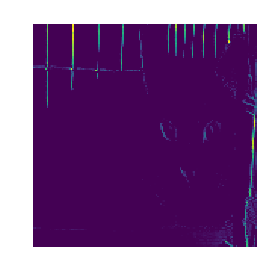

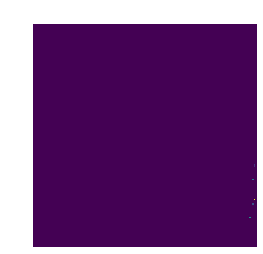

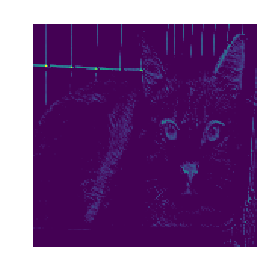

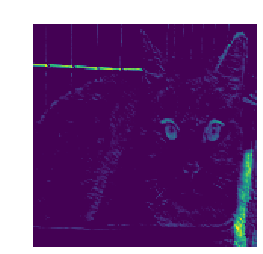

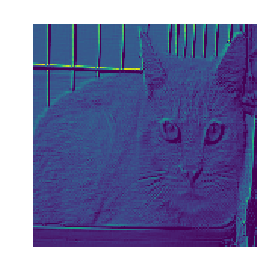

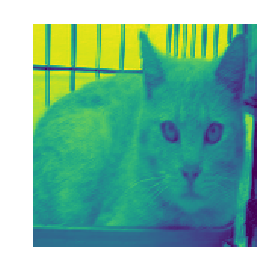

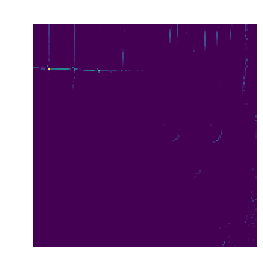

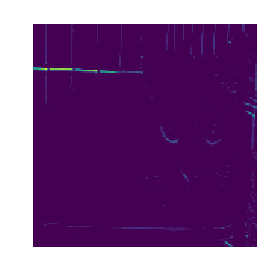

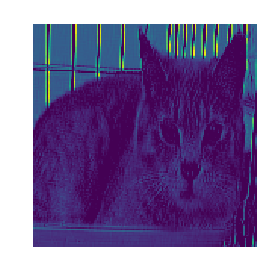

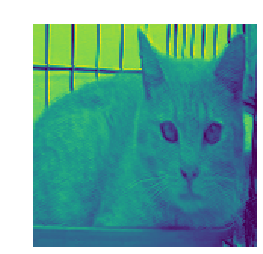

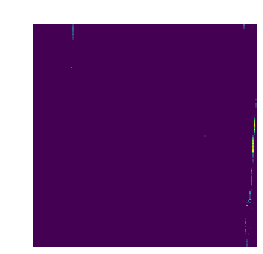

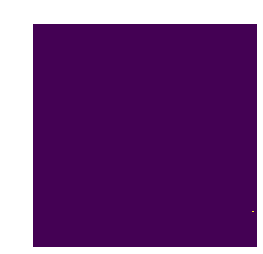

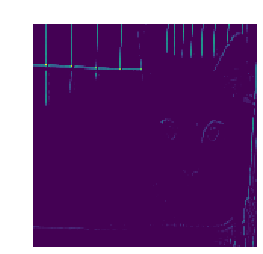

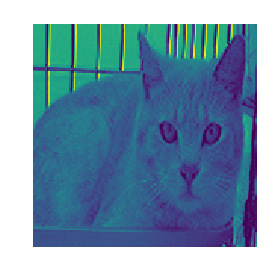

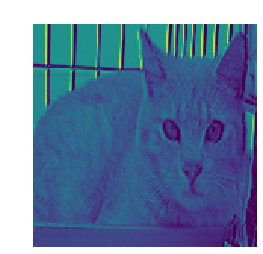

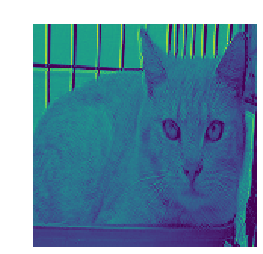

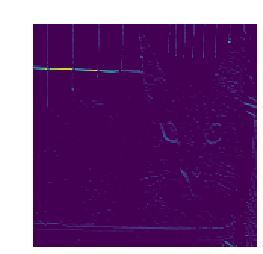

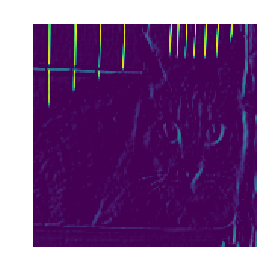

In [29]:
for i in range(32):
    plt.matshow(first_layer_activation[0,:,:,i],cmap='viridis')
    plt.axis('off')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the specific filters learned by convolution layers are not deterministic.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


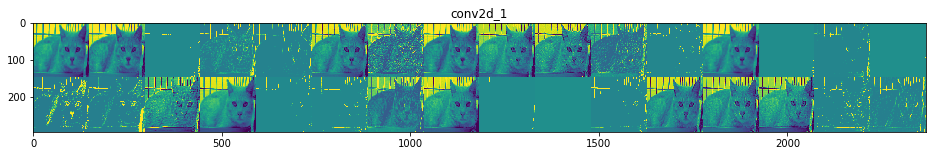

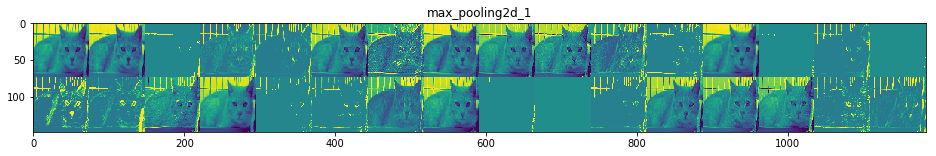

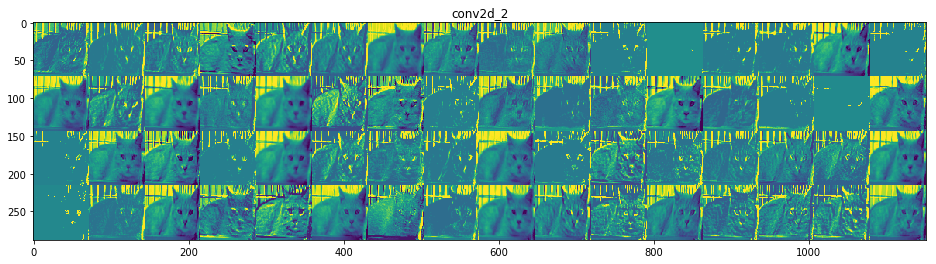

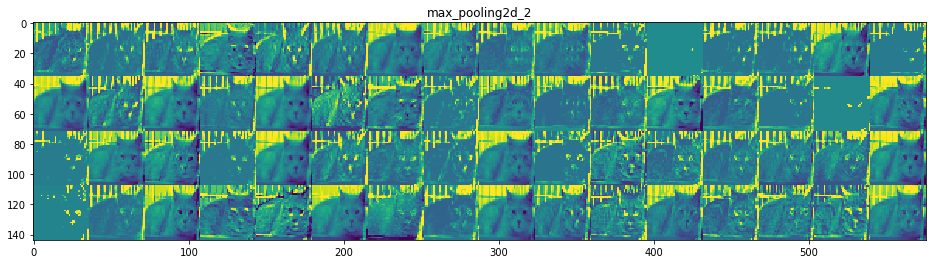

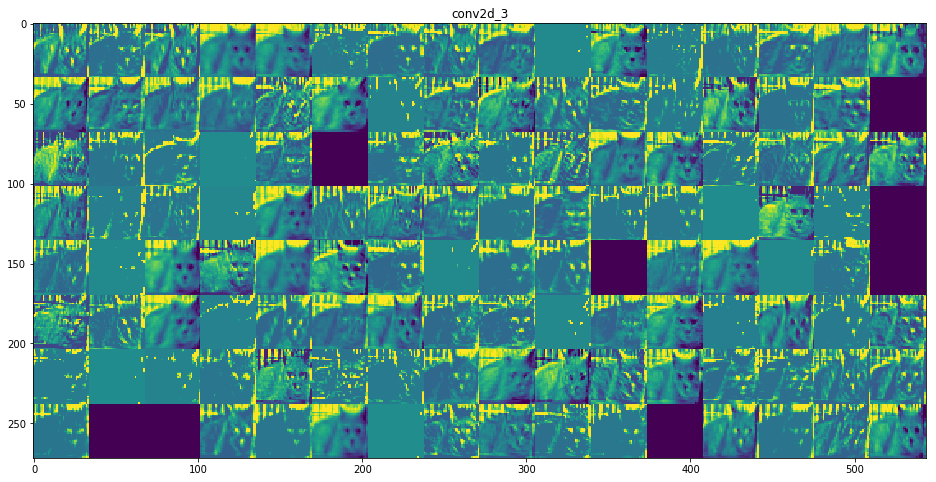

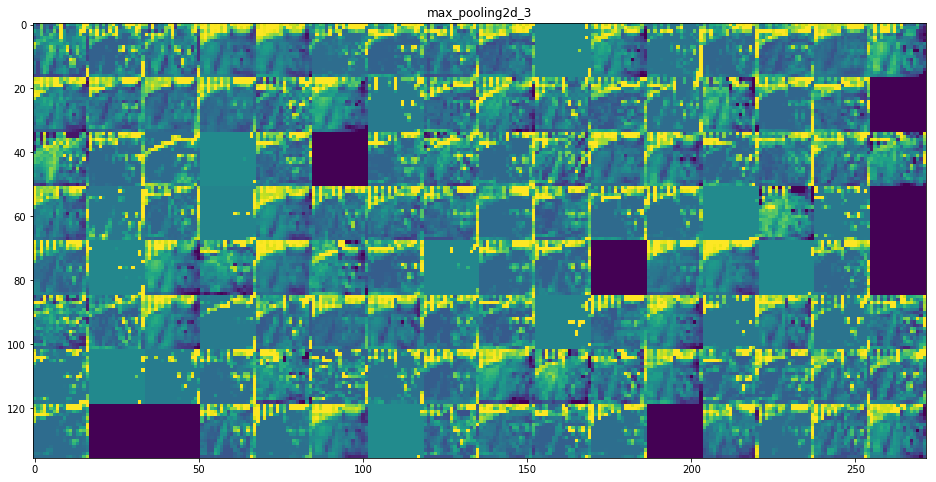

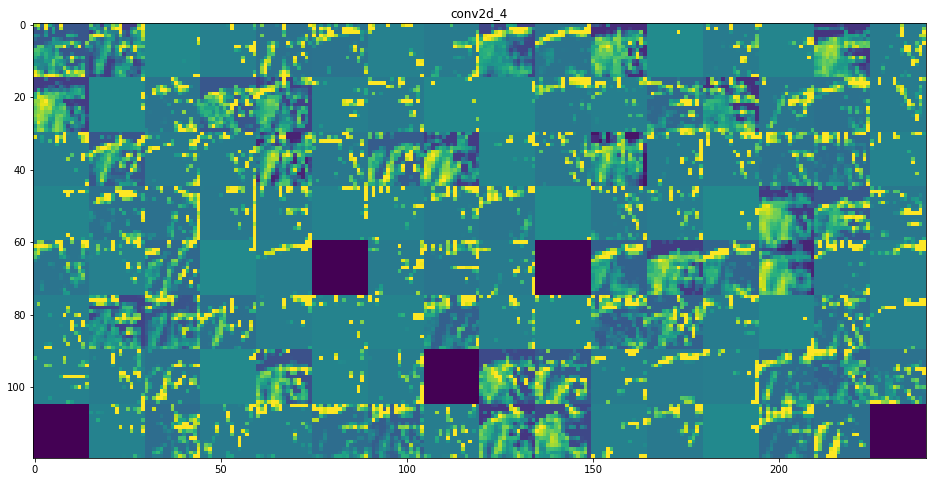

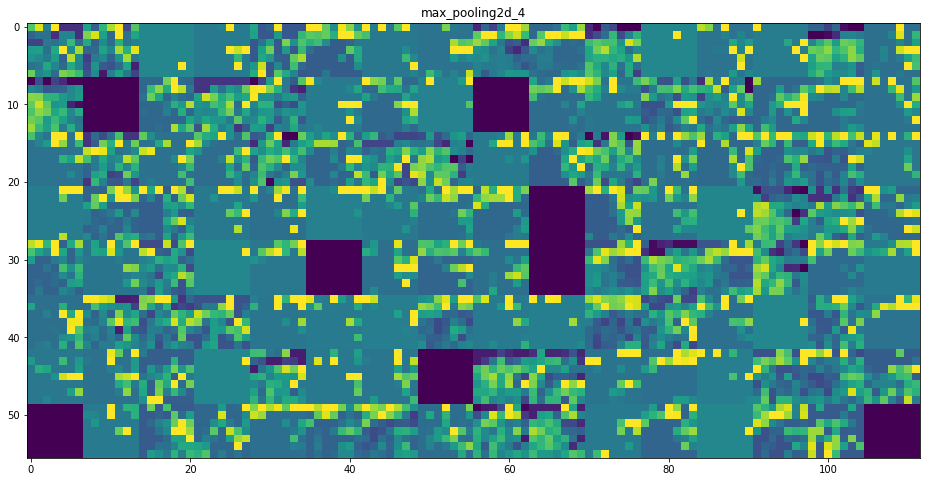

In [32]:
layer_names=[]
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row=16

for layer_name,layer_activation in zip(layer_names,activations):
    n_features = layer_activation.shape[-1]
    size=layer_activation.shape[1]
    n_cols=n_features // images_per_row
    
    display_grid=np.zeros((size*n_cols,images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image=layer_activation[0,:,:,col*images_per_row+row]
            channel_image-=channel_image.mean()
            channel_image/=channel_image.std()
            channel_image*=64
            channel_image+=128
            
            channel_image=np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size:(col+1)*size,
                        row*size:(row+1)*size]=channel_image
    scale=1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='viridis')
    
plt.show()
            

A few remarkable things to note here:

The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the information present in the initial picture.
As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the input image.
We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat or dog). A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in our case, RBG pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it tremendously difficult to remember how things around us actually look.

Visualizing convnet filters
Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [7]:
import keras
from keras.applications import VGG16
from keras import backend as K

In [8]:
model = VGG16(weights='imagenet',include_top=False)

In [9]:
layer_name='block3_conv1'
filter_index=0
layer_output=model.get_layer(layer_name).output
loss=K.mean(layer_output[:,:,:,filter_index])


In [10]:
grads=K.gradients(loss,model.input)[0]

In [11]:
grads/=K.sqrt(K.mean(K.square(grads)))+1e-5

In [12]:
iterate=K.function([model.input],[loss,grads])
import numpy as np


In [13]:
loss_value,grads_value=iterate([np.zeros((1,150,150,3))])

In [14]:
input_img_data=np.random.random((1,150,150,3))*20+128.
step=1.
for i in range(40):
    loss_value,grads_value=iterate([input_img_data])
    input_img_data+=grads_value*step
    


In [15]:
def deprocess_image(x):
    x-=x.mean()
    x/=(x.std()+1e-5)
    x*=0.1
    
    x+=0.5
    x=np.clip(x,0,1)
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x

In [16]:
def generate_pattern(layer_name,filter_index,size=150):
    layer_output=model.get_layer(layer_name).output
    loss=K.mean(layer_output[:,:,:,filter_index])
    
    grads=K.gradients(loss,model.input)[0]
    grads/=K.sqrt(K.mean(K.square(grads)))+1e-5
    iterate=K.function([model.input],[loss,grads])
    input_img_data=np.random.random((1,size,size,3))*20+128.
    
    step=1.
    for i in range(40):
        loss_value,grads_value=iterate([input_img_data])
        input_img_data+=grads_value*step
        
    img=input_img_data[0]
    return deprocess_image(img)

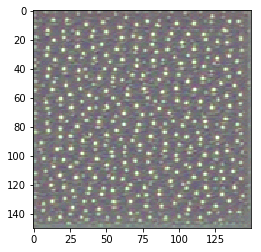

In [19]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


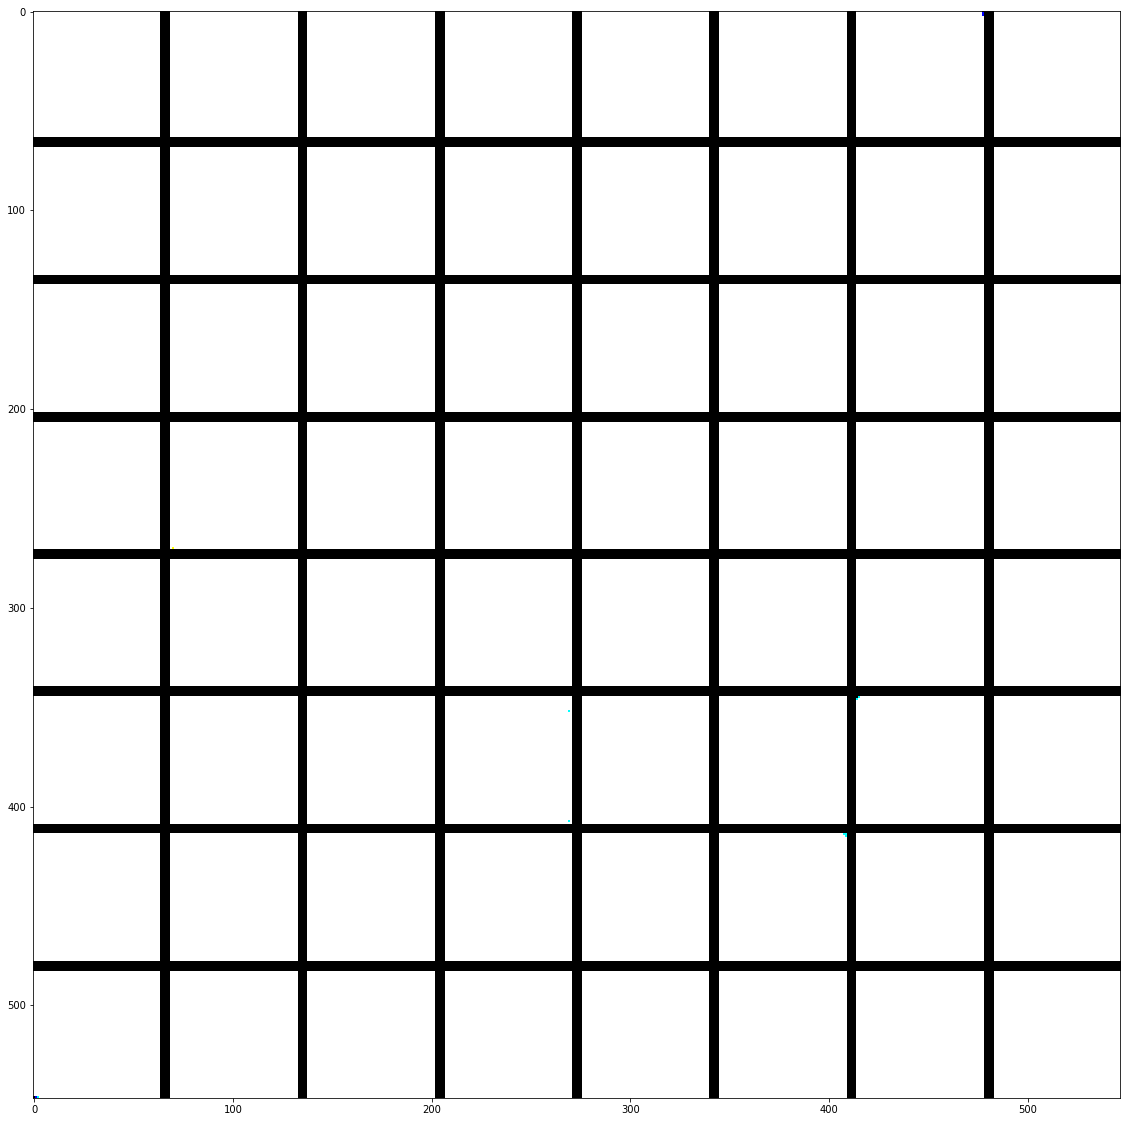

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


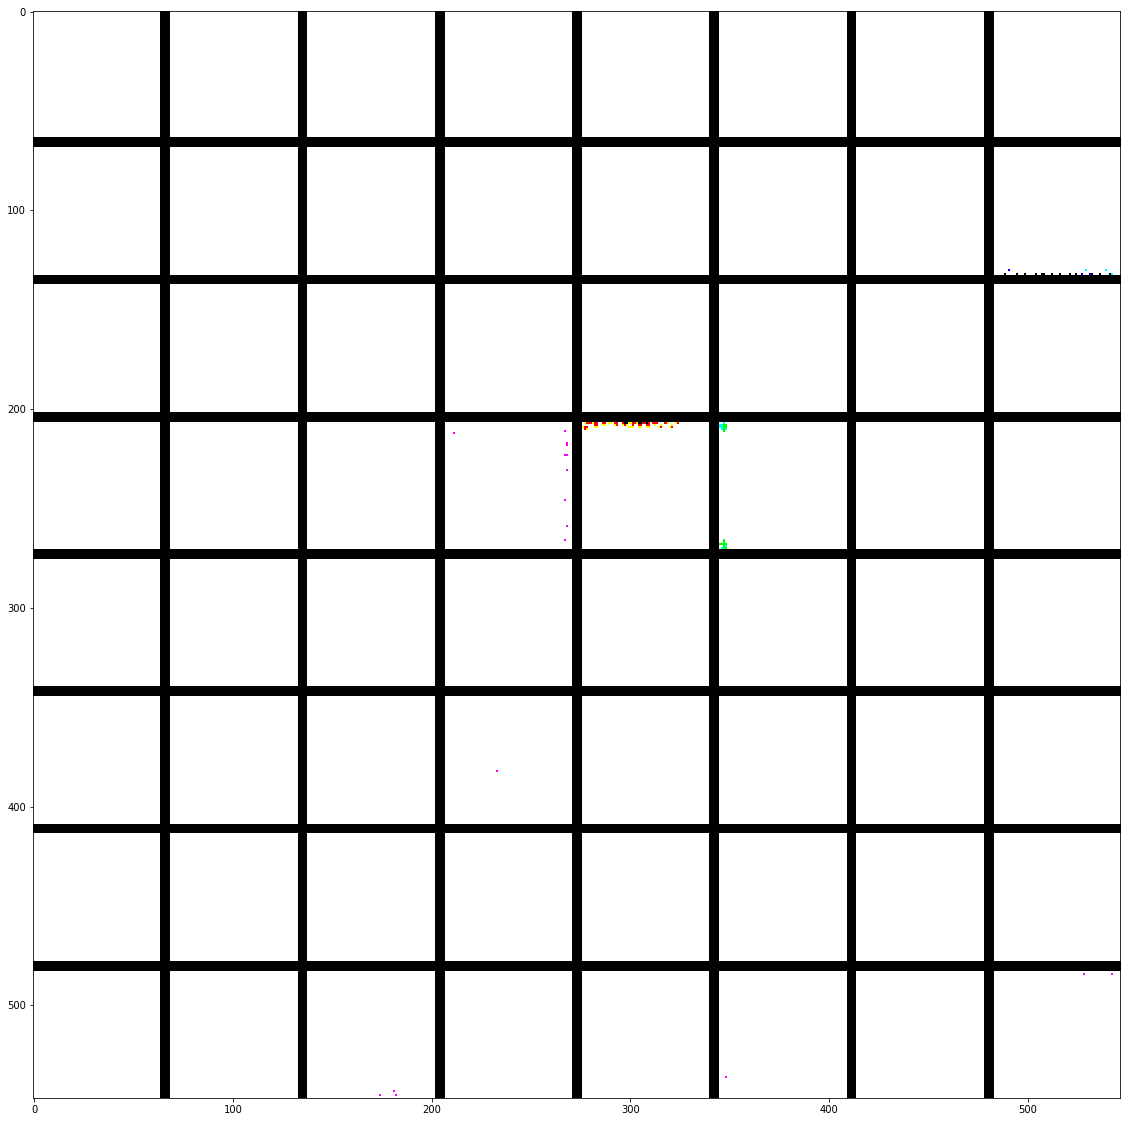

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


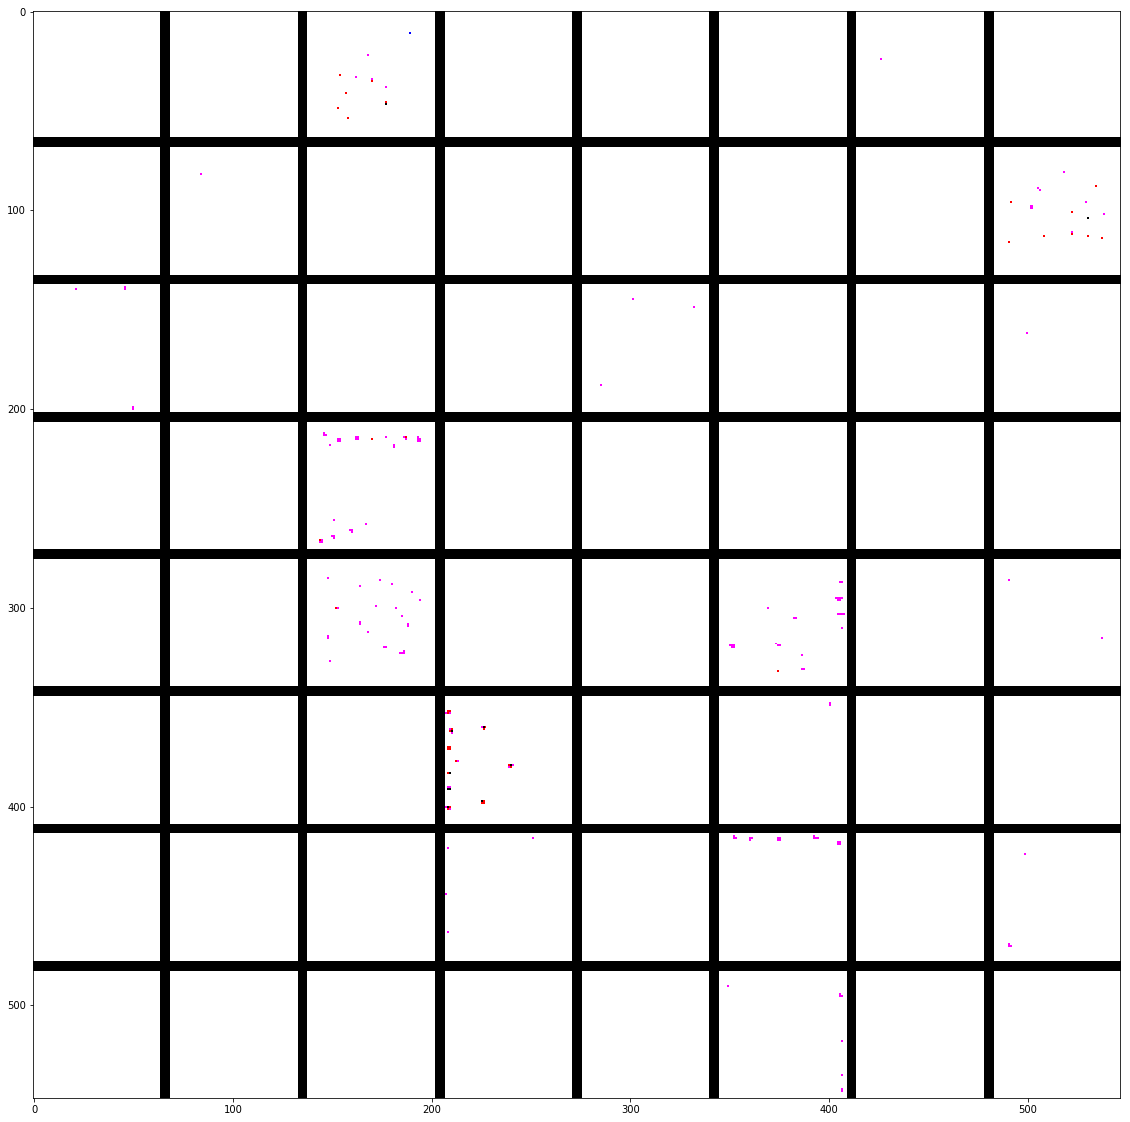

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


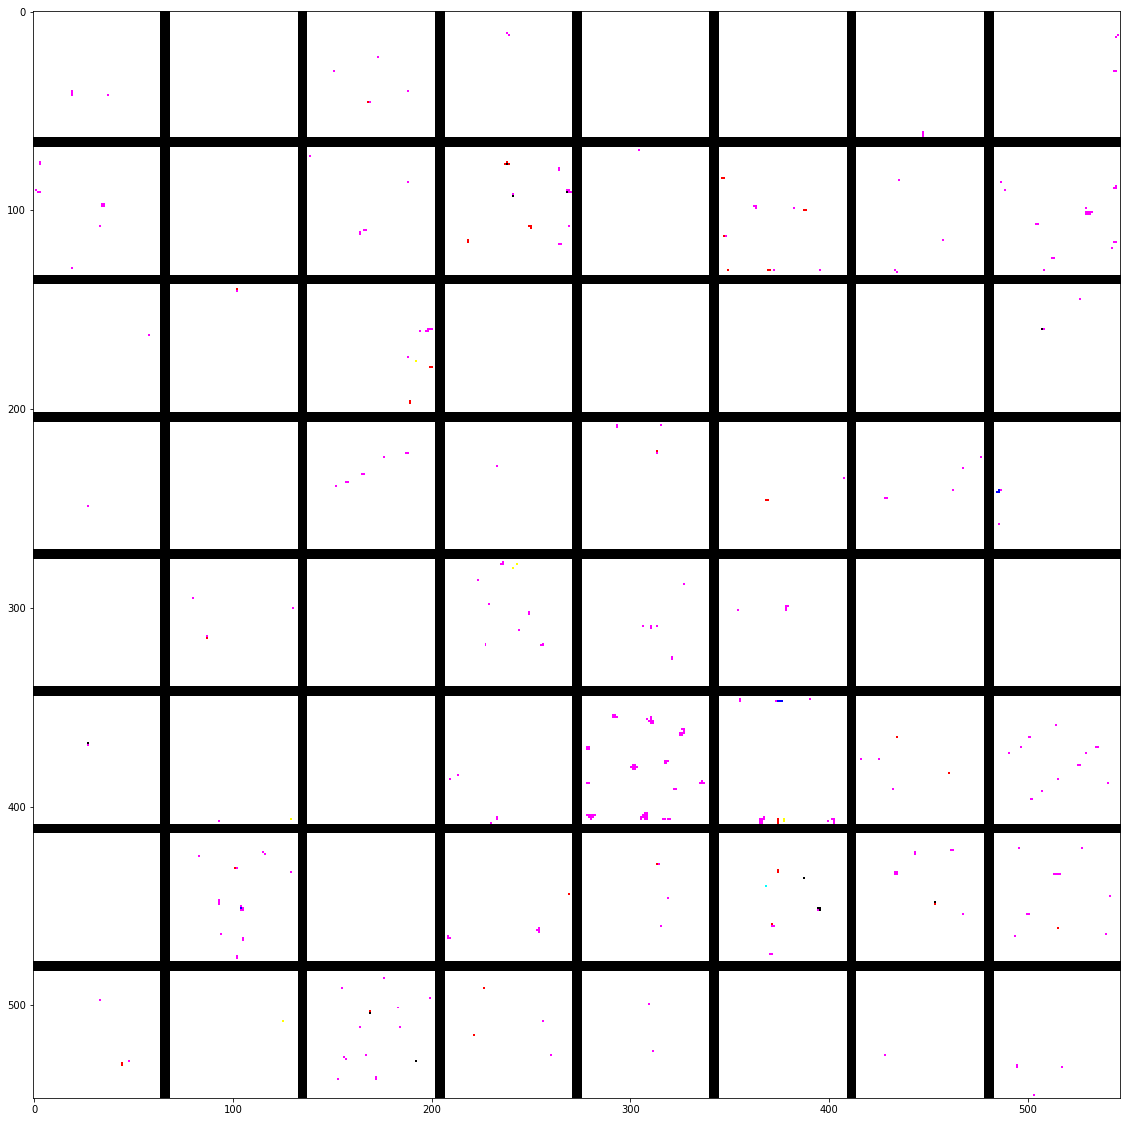

In [24]:
for layer_name in ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']:
    size=64
    margin =5
    results=np.zeros((8*size+7*margin,8*size+7*margin,3))
    for i in range(8):
        for j in range(8):
            filter_img=generate_pattern(layer_name,i+j*8,size=size)
            
            a=i*size+i*margin
            b=a+size
            c=j*size+j*margin
            d=c+size
            results[a:b,c:d,:]=filter_img
    
    plt.figure(figsize=(20,20))
    plt.imshow(results)
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [28]:
from keras.applications.vgg16 import VGG16

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification mistake. It also allows you to locate specific objects in an image.

it consists in taking the output feature map of a convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:


In [30]:
K.clear_session()
model=VGG16(weights='imagenet')

553467904/553467096 [==============================] - 888s 2us/step


In [108]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions

import numpy as np
img_path='E:/deeplearningtry/dogs-vs-cats/test1/11110.jpg'

In [121]:
img=image.load_img(img_path,target_size=(224,224))

x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)

preds=model.predict(x)
print('Predict:',decode_predictions(preds,top=5)[0])

Predict: [('n02104365', 'schipperke', 0.1467107), ('n02105056', 'groenendael', 0.13455613), ('n02124075', 'Egyptian_cat', 0.09279784), ('n04265275', 'space_heater', 0.07581888), ('n02123597', 'Siamese_cat', 0.05675188)]


In [122]:
np.argmax(preds[0])

223

The top-3 classes predicted for this image are:

African elephant (with 92.5% probability)
Tusker (with 7% probability)
Indian elephant (with 0.4% probability)
Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [119]:
golden_retriever_output=model.output[:,223]
last_conv_layer=model.get_layer('block5_conv3')
grads=K.gradients(golden_retriever_output,last_conv_layer.output)[0]

pooled_grads=K.mean(grads,axis=(0,1,2))

iterate=K.function([model.input],[pooled_grads,last_conv_layer.output[0]])

pooled_grads_value,conv_layer_output_value=iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i]*=pooled_grads_value[i]
    
heatmap=np.mean(conv_layer_output_value,axis=-1)


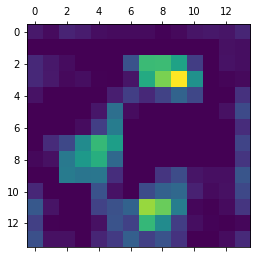

In [120]:
heatmap=np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:



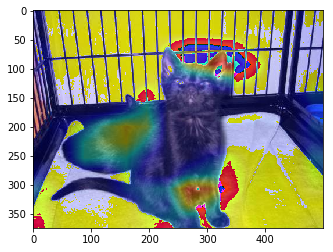

In [113]:
import cv2
img=cv2.imread(img_path)
heatmap=cv2.resize(heatmap,(img.shape[1],img.shape[0]))
heatmap=np.uint8(255*heatmap)
heatmap=cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
superimposed_img=heatmap*0.4+img
cv2.imwrite('E://1.png',superimposed_img)
plt.imshow(np.uint8(superimposed_img[:,:,::-1]))
plt.show()

In [123]:
preds[0]

array([7.55123722e-07, 6.48006244e-06, 1.32886062e-05, 5.89721594e-06,
       3.29492650e-05, 5.68871246e-06, 1.19843833e-06, 9.86726591e-05,
       1.48966123e-04, 5.96990333e-07, 1.29781625e-07, 2.08164025e-07,
       9.20427374e-06, 1.80235418e-06, 3.97250318e-07, 2.57275974e-06,
       1.28070213e-04, 2.91061988e-05, 1.17268064e-05, 1.62494837e-06,
       1.13410374e-06, 2.93045900e-07, 1.04234942e-07, 3.33431421e-06,
       9.17799071e-07, 7.15774149e-06, 1.25660736e-05, 4.68382723e-06,
       1.65535894e-05, 1.17681753e-04, 1.05860602e-06, 5.51450682e-07,
       6.84983718e-07, 1.88268160e-07, 1.35442974e-06, 8.77322350e-07,
       2.15774253e-06, 1.14572422e-05, 8.58875353e-07, 5.13141913e-06,
       1.36540366e-05, 8.50403808e-07, 4.01093246e-07, 9.74925797e-07,
       1.58875810e-05, 2.50986636e-06, 1.29688351e-05, 2.02550041e-06,
       2.74832871e-07, 3.60163449e-06, 1.62011838e-05, 6.08372648e-05,
       4.93816106e-06, 6.34809680e-07, 9.48142201e-07, 5.69553833e-07,
      